# Neural Network from nuts and bolts

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import random
import copy
import cv2
from PIL import Image as im
import feature_extractor

c:\users\jijo98\appdata\local\programs\python\python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Jijo98\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
!jupyter nbextension enable --py widgetsnbextension

## Q1 Loading the dataset

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

file = r'cifar-10-batches-py\data_batch_1'
data_batch_1 = unpickle(file)

In [334]:
print(data_batch_1.keys())


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [3]:


ROOT=r'cifar-10-batches-py'

X_train,Y_train=[], []
for b in range(1,6):
    '''Used to compile 5 batches and make the training dataset of 50k images'''
    
    loc=os.path.join(ROOT,'data_batch_%d'%(b,))
    batch=unpickle(loc)
    X_s,Y_s=batch[b'data'], batch[b'labels']
    X_s=np.array(X_s)
    Y_s=np.array(Y_s)
    
    X_train.append(X_s)
    Y_train.append(Y_s)
    
X_train=np.concatenate(X_train)
Y_train=np.concatenate(Y_train)



In [4]:
meta_file = r'cifar-10-batches-py\batches.meta'
meta_data = unpickle(meta_file)

In [5]:
print(meta_data.keys())

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


In [338]:
print(meta_data[b'label_names'])

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


Shape before reshape: (50000, 3072)
Shape after reshape and before transpose: (50000, 3, 32, 32)
Shape after reshape and transpose: (50000, 32, 32, 3)


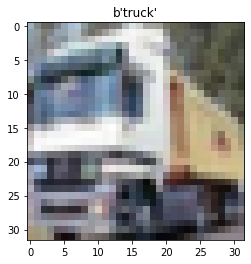

In [6]:
'''Reshaping and transpose operation to make the dataset fit for further processing'''

print("Shape before reshape:", X_train.shape)
# Reshape the whole image data
X_train = X_train.reshape(len(X_train),3,32,32)
print("Shape after reshape and before transpose:", X_train.shape)
# Transpose the whole data
X_train = X_train.transpose(0,2,3,1)
print("Shape after reshape and transpose:", X_train.shape)
plt.imshow((X_train[1]).astype(np.uint8))
plt.title(meta_data[b'label_names'][Y_train[1]])
plt.show()

In [ ]:
plt.imshow(X_train[1])
plt.title(meta_data[b'label_names'][data_batch_1[b'labels'][1]])
plt.show()

In [ ]:
data_batch_1[b'labels']

## Q2 Image Transformation
### (a)Random Rotation

In [7]:
def random_rotation(image):
    '''Function responsible for rotating the image with a random angle b/w -180 to 180'''
    
    angle=random.uniform(-180,180)
    
    angle=math.radians(angle)                               #converting degrees to radians
    cosine=math.cos(angle)
    sine=math.sin(angle)
    height=image.shape[0]                                   #define the height of the image
    width=image.shape[1]                                    #define the width of the image

    # Define the height and width of the new image that is to be formed

    
    new_height=height
    new_width=width

    # define another image variable of dimensions of new_height and new _column filled with zeros

    output=np.zeros((new_height,new_width,image.shape[2]),dtype=int)

    # Find the centre of the image about which we have to rotate the image
    original_centre_height   = image.shape[0]//2   #with respect to the original image
    original_centre_width    = image.shape[1]//2   #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= new_height//2       #with respect to the new image
    new_centre_width= new_width//2          #with respect to the new image

    for i in range(height):
        for j in range(width):
            #co-ordinates of pixel with respect to the centre of original image
            y=i-original_centre_height                   
            x=j-original_centre_width                       

            #co-ordinate of pixel with respect to the rotated image
            new_y=round(-x*sine+y*cosine)
            new_x=round(x*cosine+y*sine)

       
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            # adding if check to prevent any errors in the processing
            if 0 <= new_x < new_width and 0 <= new_y < new_height and new_x>=0 and new_y>=0:
                output[new_y,new_x,:]=image[i,j,:]     
    
  
    
    
    return output

(32, 32, 3)


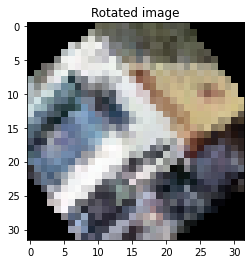

In [99]:
output=random_rotation(X_train[1])
print(output.shape)
plt.imshow(output.astype(np.uint8))
plt.title('Rotated image')
plt.show()

### (b) Random cutout

In [8]:
def random_cutout(image):
    
    '''Responsible for cutting out a portion of image randomly'''
    
    output=image
    cutout_pixels=random.choice(range(1,17)) #Will choose a random number x within the range and cutout x^2 portion from the original image
    
    #Intializing the starting point from where we'll start cutting out the image
    x_start=random.randint(0,output.shape[0]+1-cutout_pixels)
    y_start=random.randint(0,output.shape[1]+1-cutout_pixels)
    
    #Cutting out is essentially setting the pixels within a particular area to 0
    for i in range(x_start,image.shape[0]-cutout_pixels):
        for j in range(y_start,image.shape[1]-cutout_pixels):
            output[i][j]=0
            
   
    
    return output
    

(32, 32, 3)


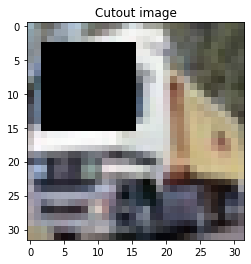

In [11]:
output=random_cutout(copy.deepcopy(X_train[1]))
print(output.shape)
plt.imshow(output.astype(np.uint8))
plt.title('Cutout image')
plt.show()

### (c) Random Cropping after Padding

In [12]:
def random_cropping(image):
    '''Used to crop out a portion of image after padding it with 2 pixels on all sides'''
    
    output=np.zeros([image.shape[0]+4,image.shape[1]+4,image.shape[2]],dtype=int) #Padding with black
    output[2:34,2:34]=copy.deepcopy(image)
    
    #Intializes the starting pixel from where we'll start cropping out the image while making sure that we don't cross the boundary
    x_start=random.randint(0,output.shape[0]-32)
    y_start=random.randint(0,output.shape[1]-32)
    
    #Simple logic to extract some pixels from the image
    cropped_img=output[x_start:x_start+32,y_start:y_start+32]

    
    return cropped_img
    

(32, 32, 3)


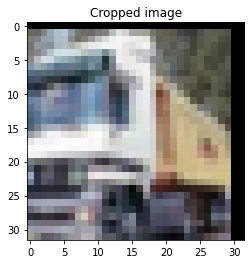

In [12]:
output=random_cropping(copy.deepcopy(X_train[1]))
print(output.shape)
plt.imshow(output)
plt.title('Cropped image')
plt.show()

### (d) Contrast Adjusting & Horizontal flipping

In [13]:
def con_n_flip(image):
    '''Used for adjusting the contrast of image and flipping the image horizontally'''
    
    #Constrast Adjustment
    alpha=random.uniform(0.5,2.0)
    
    
    image[:,:,:]=alpha*(image[:,:,:]-128) + 128
    
    #Pixel Clipping
    image[image>255]=255
    image[image<0]=0

    #Horizontal Flipping
    flip_decision=random.choices([0,1],[0.5,0.5])
    output=np.zeros((image.shape[0],image.shape[1],image.shape[2]))
    if(flip_decision):
        for i in range(image.shape[0]):
            output[:,i,:]=image[:,image.shape[1]-i-1,:]
            
    
    
    return output

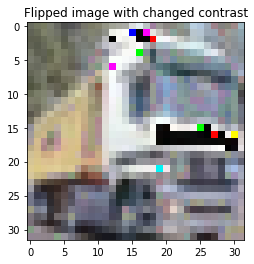

In [14]:
output=con_n_flip(copy.deepcopy(X_train[1]))
plt.imshow(output/255.0)
plt.title('Flipped image with changed contrast')
plt.show()

In [16]:
#Image normalization and reshaping
X_train_norm=X_train/255
X_train_norm = X_train_norm.reshape(len(X_train_norm),3,32,32)
X_train_norm = X_train_norm.transpose(0,2,3,1)

## Q3 Data Augmentation
 

In [17]:

def data_aug(X_train):
    '''Creates the augmented dataset by applying augmentation operations on every image of original dataset
     and appending each augmented image with the original dataset'''
    
    data_pts=X_train.shape[0]
    augment=[random_rotation, random_cutout, random_cropping, con_n_flip]
    aug=[]
  
    #Randomly chooses an augmentation and applies it image
    for i in range(data_pts):
        
        aug_choice=random.choices(range(4),k=1)[0]
        
        aug.append(augment[aug_choice](copy.deepcopy(X_train[i])))
      
        
        
     
    aug=np.array(aug)
    X_train=np.array(X_train)
    print(X_train.dtype, aug.shape)
    augmented_data=np.concatenate([X_train, aug])

    return augmented_data
        
        


In [30]:
X_train_aug=data_aug(X_train_norm)



float64 (50000, 32, 32, 3)


In [ ]:
X_train.shape
out = cv2.resize(X_train[0], (224, 224))
out.shape
plt.imshow(out)
plt.show()

## Q4. Feature extractor

In [18]:

def feature_extract(image):
    
    '''Function using the feature_extractor.py file for extracting features and converting it to trainable form which is a flattened vec of size 512 features'''
    #Reshaping images of size 3*32*32 to 3*224*224
    new_data=np.zeros(shape=(image.shape[0],512),dtype='float32')
    res_obj=feature_extractor.BBResNet18()
    for i in range(image.shape[0]):
        
        
        out =cv2.resize(image[i], (224, 224))
        
        out=out.transpose(2,1,0)
        out=out.reshape(1,3, 224, 224)
       
        new_data[i]=res_obj.feature_extraction(out.astype('float32'))
        
   
    
    print(new_data.shape)
 
#     out=res_obj.feature_extraction(new_data)
    

    return new_data



In [153]:
# flat_train=feature_extract(copy.deepcopy(X_train_norm))


(50000, 512)


## Extracted Features have been stored in a file and is loaded with the code below:

In [19]:
#Loading the extracted features from the file, for training on un_augmented dataset we just need to run the model on first 50k data points
flat_train_aug=np.load('aug_train_features.npy')

In [41]:
#Loading test dataset
ROOT=r'cifar-10-batches-py'

loc=os.path.join(ROOT,'test_batch')
batch=unpickle(loc)
X_test,Y_test=batch[b'data'], batch[b'labels']


X_test_norm=X_test/255
X_test_norm = X_test_norm.reshape(len(X_test_norm),3,32,32)
X_test_norm = X_test_norm.transpose(0,2,3,1)

In [40]:
# flat_test=feature_extract(X_test_norm)
flat_test=np.load('test_data_features.npy')

## Q5 Implementing Forward Pass

In [37]:
def one_hot_encoder(labels):
    
    '''Helper function take in categorical labels as input and producing one-hot encoded vector as output'''
    labels=np.array(labels)
    out_encode=np.zeros((np.max(labels)+1,labels.shape[0]),dtype=int)
   
    for i in range(labels.shape[0]):
        
        out_encode[labels[i]][i]=1
        
        
    return out_encode   
    
def par_ini(inp, hid, out):
    
    '''Responsible for initializing parameters'''
    
    W1=np.random.randn(hid,inp)/1e3
    b1=np.zeros((hid,1))
    W2=np.random.randn(out,hid)/1e3
    b2=np.zeros((out,1))
    param= {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2}
    return param


def relu(x):
    '''Helper function to calculate ReLU'''
    
    return np.maximum(0,x)
    
    
def softmax(X):
    '''Helper function to calculate softmax'''
    e=np.exp(X)
    return e/np.sum(e)

def forward_prop(X, param):
   
    '''Function implementing forward_prop'''
   
    #Initializing weight parameters
    W1=param['W1']
    b1=param['b1']
    W2=param['W2']
    b2=param['b2']
    
   
    #Output of first hidden layr
    h1=np.matmul(W1,X.T)+b1 #64*number of training pts
   
    #Activation of first hidden layer
    a1= relu(h1)
    
    #Output of the last layer
    o=np.matmul(W2,a1)+b2
    
    #Softmax activated output of the last layer indicating probability of each class
    a2=[softmax(o[:,i]) for i in range(X.shape[0])]
    
    memory= {"h1":h1, "a1":a1, "o":o, "a2":a2}
    
    return a2, memory

def cat_cross_entrop(pred,actual):
    '''Helper function to calculate categorical cross entropy loss'''
    
    
    loss=-np.sum(actual*np.log(pred))
    
    return loss/len(pred)


    
    
    


(10, 50000)

In [42]:
labels_encoded=one_hot_encoder(Y_train) # 10,50k
labels_encoded_aug=np.concatenate([labels_encoded,labels_encoded], axis=1)
labels_encoded_test=one_hot_encoder(Y_test)

In [22]:
labels_encoded_aug.shape

(10, 100000)

In [407]:
parameters=par_ini(512,64,10)
fp, memo=forward_prop(flat_train[:50],parameters)

## Q6. & Q7. Backpropagation, training and testing

In [23]:
def backprop(parameters, memo, X, Y):
    
    '''Function to calculate backprop'''
    
    
    W1=parameters['W1']
    W2=parameters['W2']
    a1=np.array(memo['a1'])
    a2=np.array(memo['a2'])
    batch_size=X.shape[0]
    
    dz2= (a2-Y) #b*10
   
    dW2= (1/batch_size)*np.matmul(dz2.T,a1.T)  #shape is 10*64
    # print(dW2.shape, dz2.shape)
   
    db2= (1/batch_size)*dz2 # np.matmul(dz2,np.identity(10)) # shape is b*10
    
    da1= np.matmul(dz2,W2)  #b*64
   
   
    
    dz1 = np.multiply(da1, (memo['h1']>0).T)  # shape is b*64
        
    dW1=(1/batch_size)*np.matmul(dz1.T, X) #64*512
  
    db1= (1/batch_size)*dz1 # np.matmul(dz1,np.identity(64)) #b*64
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2,"db2": db2}
    
    return grads

In [26]:
def grad_desc(param, grads, lr):
    
    '''Implementation of Gradient descent'''
    
    W1=param['W1']
    b1=param['b1']
    W2=param['W2']
    b2=param['b2']
    
    dW1=grads['dW1']
    db1=grads['db1']
    dW2=grads['dW2']
    db2=grads['db2']
    
    W1=W1- lr*dW1
    b1=(b1.T- lr*db1).T
    W2=W2- lr*dW2
    b2=(b2.T- lr*db2).T
    
    b1=b1[:,0].reshape((b1[:,0].shape[0],1))
    b2=b2[:,0].reshape((b2[:,0].shape[0],1))
    
    parameters= {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2}
    
    return parameters
    

In [28]:
def train_NN(flat_train,labels_encoded, batch_size=128, lr=0.01):
    '''Function for training the Neural Network and returning the learned parameters'''
    
    parameters=par_ini(input_units, hidden_units, output_units)
    W1=parameters['W1']
    b1=parameters['b1']
    W2=parameters['W2']
    b2=parameters['b2']
  
    acc_log=[]
    cost_log=[]
    epochs_log=[]
    for epochs in range(1,121):
    
        itr=flat_train.shape[0]//batch_size
        acc=0
        for batch in range(0, flat_train.shape[0]-batch_size, batch_size):
            A2, memo= forward_prop(flat_train[batch:batch+batch_size, :], parameters)
        
            cost=cat_cross_entrop(A2, (labels_encoded.T)[batch:batch+batch_size,:])
            grads=backprop(parameters, memo, flat_train[batch:batch+batch_size, :], (labels_encoded.T)[batch:batch+batch_size,:])
            parameters=grad_desc(parameters,grads, lr)
      
            #print(np.argmax(labels_encoded.T, axis=1), labels_encoded.T)
            acc += np.sum(np.argmax(A2, axis=1) == np.argmax((labels_encoded.T)[batch:batch+batch_size,:], axis=1))
#         print(accuracy_score(A2, labels_encoded.shape))
       
        
        if epochs % 10 == 0:
            acc_log.append((acc/flat_train.shape[0])*100)
            cost_log.append(cost)
            epochs_log.append(epochs)
            print ("Cost after epochs %d: %f and accuracy=%f" %(epochs, cost, (acc/flat_train.shape[0])*100))
                
       
    return parameters,acc_log,cost_log, epochs_log

## Load the test file by using the following code and also extract features by running the cell following it

In [29]:
ROOT=r'cifar-10-batches-py'

loc=os.path.join(ROOT,'test_batch')
batch=unpickle(loc)
X_test,Y_test=batch[b'data'], batch[b'labels']


X_test_norm=X_test/255
X_test_norm = X_test_norm.reshape(len(X_test_norm),3,32,32)
X_test_norm = X_test_norm.transpose(0,2,3,1)

In [30]:
#Loading feature extracted test set
flat_test=np.load('test_data_features.npy')

In [32]:
input_units=512
hidden_units=64
output_units=10

In [52]:
#Training on Non_Augmented dataset, but no need of tranining as trained parameters are loaded in the following cells
parameters, acc_aug_unaug, cost_log_unaug, epochs=train_NN(flat_train_aug[:50000], labels_encoded, 64, 0.01)


Cost after epochs 10: 0.672080 and accuracy=76.298000
Cost after epochs 20: 0.629671 and accuracy=79.312000
Cost after epochs 30: 0.605288 and accuracy=80.352000
Cost after epochs 40: 0.583751 and accuracy=81.094000
Cost after epochs 50: 0.559040 and accuracy=81.814000
Cost after epochs 60: 0.543904 and accuracy=82.358000
Cost after epochs 70: 0.528522 and accuracy=82.870000
Cost after epochs 80: 0.514821 and accuracy=83.346000
Cost after epochs 90: 0.502709 and accuracy=83.940000
Cost after epochs 100: 0.486513 and accuracy=84.434000
Cost after epochs 110: 0.467480 and accuracy=84.924000
Cost after epochs 120: 0.448516 and accuracy=85.358000


In [53]:
# Saving trained weights for non-augmented data
# np.save('Non_aug_parameters', parameters)

In [54]:
#Loading non_augmented trained parameters
param_non=np.load('Non_aug_parameters.npy', allow_pickle=True).item()

In [55]:
#Test accuracy post training on Unaugmented data
pred, _= forward_prop(flat_test, param_non)
cost=cat_cross_entrop(pred, labels_encoded_test.T)
cost,np.sum(np.argmax(pred, axis=1) == np.argmax((labels_encoded_test.T), axis=1))/100

(0.6037571923323269, 79.77)

In [60]:
#Training on Augmented dataset, but no need of tranining as trained parameters are loaded in the following cells
parameters, acc_aug, cost_log_aug, _=train_NN(flat_train_aug, labels_encoded_aug, 64, 0.01)


Cost after epochs 10: 0.854010 and accuracy=71.112000
Cost after epochs 20: 0.809949 and accuracy=73.312000
Cost after epochs 30: 0.789140 and accuracy=74.507000
Cost after epochs 40: 0.761637 and accuracy=75.501000
Cost after epochs 50: 0.728593 and accuracy=76.300000
Cost after epochs 60: 0.694342 and accuracy=76.955000
Cost after epochs 70: 0.670465 and accuracy=77.566000
Cost after epochs 80: 0.647683 and accuracy=78.048000
Cost after epochs 90: 0.633493 and accuracy=78.567000
Cost after epochs 100: 0.610293 and accuracy=78.936000
Cost after epochs 110: 0.591463 and accuracy=79.365000
Cost after epochs 120: 0.585620 and accuracy=79.742000


In [57]:
#Saving Augmented Parameters
# np.save('Aug_parameters', parameters)

In [58]:
#Loading Augmented Parameters
param_aug=np.load('Aug_parameters.npy', allow_pickle=True ).item()

In [ ]:
#Test accuracy post training on Augmented data
pred, _= forward_prop(flat_test, param_aug)
cost=cat_cross_entrop(pred, labels_encoded_test.T)
cost,np.sum(np.argmax(pred, axis=1) == np.argmax((labels_encoded_test.T), axis=1))/100

In [282]:
print('Loss=%f, Accuracy=%f'%(cost,np.sum(np.argmax(pred, axis=1) == np.argmax((label_encoded_test.T), axis=1))/100))

Loss=0.596115, Accuracy=80.200000


Text(0.5, 1.0, 'Loss plot')

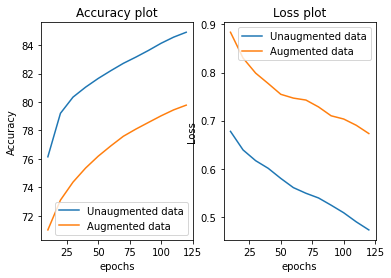

In [294]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, acc_aug_unaug, label='Unaugmented data')
ax1.plot(epochs, acc_aug, label='Augmented data')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_title('Accuracy plot')

ax2.plot(epochs, cost_log_unaug, label='Unaugmented data')
ax2.plot(epochs, cost_log_aug, label='Augmented data')
ax2.legend()
ax2.set_xlabel('epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss plot')

# ax2.scatter(x, y)

In [508]:
X_test_norm.shape

(10000, 32, 32, 3)

(10000, 512)
